In [1]:
from network import scGen
import scanpy.api as sc
import numpy as np
import wget
from scipy.sparse import csr_matrix


In [2]:
path_to_save = "../results"
sc.settings.figdir = path_to_save

Downloading the train and validation data for Salmonella dataset from Haber et al. dataset and saving them in data folder

In [3]:
train_url = "https://drive.google.com/uc?export=download&id=1U0XLp0X9i73FHJMYOHrlPwWdyaAUFI95"
validation_url = "https://drive.google.com/uc?export=download&id=1vW3r7J1DKYc13S5l4HKG5TaKhNFXcHn1"
t = wget.download(train_url, "../data/train_salmonella.h5ad")
v = wget.download(validation_url, "../data/valid_salmonella.h5ad")



Reading train and validation data

In [4]:
train =  sc.read("../data/train_salmonella.h5ad")
validation = sc.read("../data/valid_salmonella.h5ad")
#training cells
c_in = ['Goblet','Endocrine',"TA","Tuft",'Enterocyte.Progenitor','Stem','Enterocyte']
#heldout cells
c_out =  ['TA.Early']

In [5]:
train.obs["cell_type"] = train.obs["cell_label"]
validation.obs["cell_type"] = validation.obs["cell_label"]
train.X = csr_matrix(train.X)
validation.X = csr_matrix(validation.X)

Lets now make the scGen object with training, validation and condition labels with training and held out cells

In [7]:
scg = scGen(train,validation,{"ctrl":"Control", "stim":"Salmonella"}, c_in, 
            c_out, dr_rate=0.5, model_path= "../models/Salmonella")

we train the model for 150 epochs 

In [6]:
scg.train(150)


----Training----
Model saved in file: ./models/Salmonella
Training finished


Making the predictin for TA.Early cells




In [9]:
pred, delta = scg.predict('TA.Early')


Extracting both control TA.Early cells from the data

In [10]:
adata_list = scg.dr.extractor(train,"TA.Early")

Applying the differential test to find out the genes differentially expressed after
the salmonella infection

In [11]:
sc.tl.rank_genes_groups(adata_list[3], groupby="condition")

Extracting top 5 up and downregulated DE genes between control and infected TA.Early cells

In [12]:
gene_list = adata_list[3].uns['rank_genes_groups']['names']["Salmonella"].tolist()[0:5] + \
            adata_list[3].uns['rank_genes_groups']['names']["Control"].tolist()[0:5]

Making one single adata object that contains control, real and predicted TA.Early cells 

In [13]:
all_Data = sc.AnnData(np.concatenate([adata_list[1].X.A, adata_list[2].X.A,pred]),)
all_Data.obs["condition"] = ["ctrl"] * len(adata_list[1].X.A) + ["real_stim"] * len(adata_list[2].X.A) + \
                            ["pred_stim"] * len( pred)
all_Data.var_names = adata_list[3].var_names

Comparing average expression of predcited, real and control cells over all genes for TA.Early cells while labeling top 5 up and downregulated DE genes 


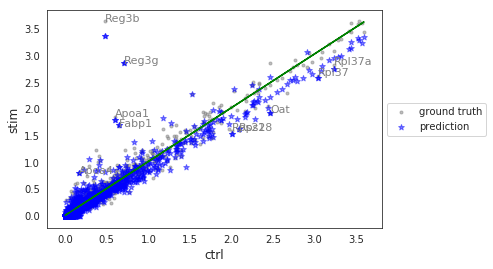

In [14]:
scg.dr.reg_overlap_plot(all_Data,gene_list,path_to_save, "scGen_Salmonella")

Mean matching for TA.Early cells for all genes

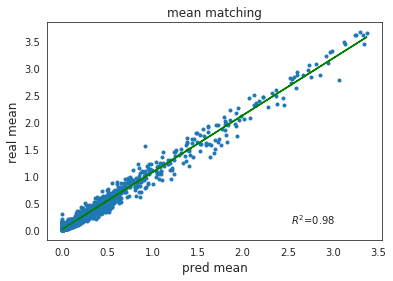

In [15]:
scg.dr.reg_mean_plot(all_Data, "../results/", "scGen_Salmonella")


Now, we visualize control, real and predicted TA.Early cells using UMAP 

         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'condition' as categorical
saving figure to file ../results/umap_scGen_Salmonella.pdf


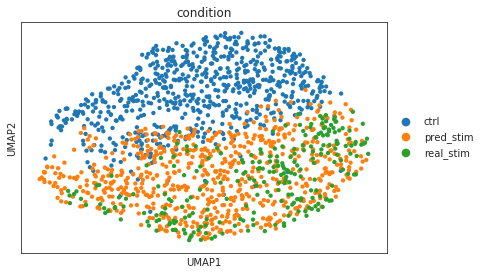

In [16]:
sc.pp.neighbors(all_Data)
sc.tl.umap(all_Data)
sc.pl.umap(all_Data, color = ["condition"],  save="_scGen_Salmonella.pdf")